In [30]:
from asim.training.models.sim_agent.smart.smart import SMART
from asim.training.models.sim_agent.smart.smart_config import SmartConfig

In [31]:
config = SmartConfig()
smart_model = SMART(config)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Map: nuplan_us-nv-las-vegas-strip'}>)

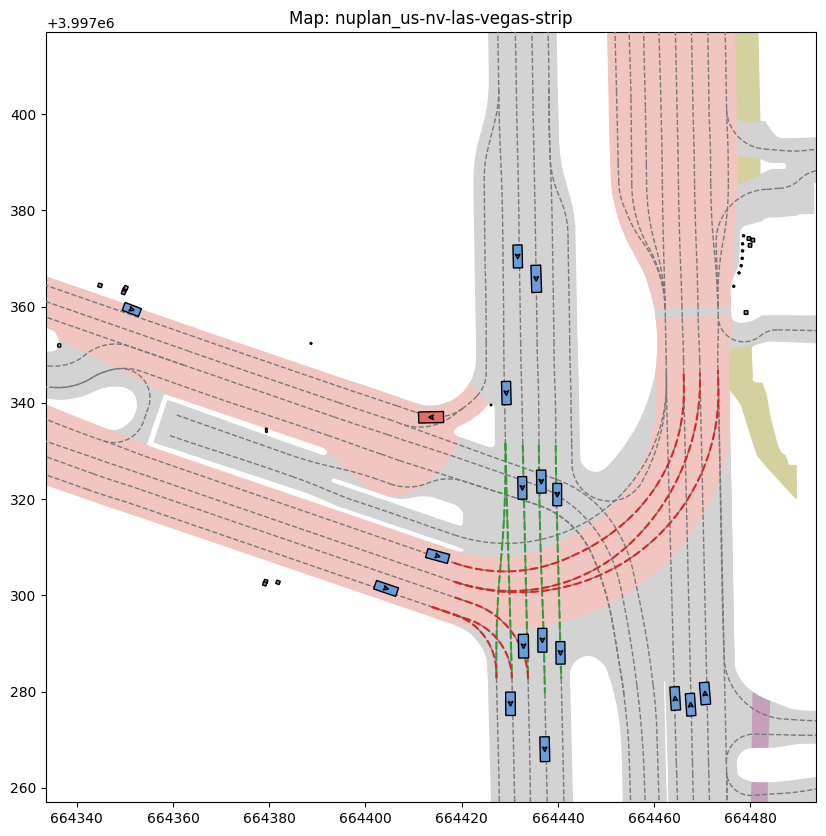

In [32]:
from pathlib import Path
from asim.dataset.scene.arrow_scene import ArrowScene
from asim.common.visualization.matplotlib.plots import plot_scene_at_iteration

from asim.dataset.scene.scene_builder import ArrowSceneBuilder
from asim.dataset.scene.scene_filter import SceneFilter

from nuplan.planning.utils.multithreading.worker_sequential import Sequential


log_names = None
split = "nuplan_mini_val"
scene_filter = SceneFilter(
    split_names=[split], log_names=log_names, timestamp_threshold_s=8.0, duration_s=8.0, history_s=1.0
)
scene_builder = ArrowSceneBuilder("/home/daniel/asim_workspace/data")
worker = Sequential()
# worker = RayDistributed()
scenes = scene_builder.get_scenes(scene_filter, worker)
scene = scenes[23]
plot_scene_at_iteration(scene, iteration=0)

In [33]:
from math import e
from typing import List

from shapely import intersection
import shapely
from asim.common.geometry.base import StateSE2
from asim.common.geometry.bounding_box.bounding_box import BoundingBoxSE2, BoundingBoxSE2Index
from asim.common.geometry.line.polylines import PolylineSE2
from asim.dataset.maps.abstract_map import MapSurfaceType
from asim.dataset.maps.abstract_map_objects import AbstractCrosswalk, AbstractLaneGroup
from asim.dataset.scene.arrow_scene import AbstractScene

from asim.training.models.sim_agent.smart.layers.attention_layer import Optional
import numpy as np
import numpy.typing as npt


def smart_feature_builder(scene: AbstractScene):

    map_features = smart_map_feature_builder(scene)

    pass


def _split_segments(
    polyline: PolylineSE2,
    num_points: int,
    segment_length: float,
    map_bounding_box: Optional[BoundingBoxSE2] = None,
) -> List[npt.NDArray[np.float64]]:
    """
    Splits a polyline into segments with a specified number of points.
    """

    segments_distances = np.concatenate([np.arange(0.0, polyline.length, step=segment_length), [polyline.length]])
    polygon = map_bounding_box.shapely_polygon if map_bounding_box is not None else None

    segments = []
    for segment_start, segment_end in zip(segments_distances[:-1], segments_distances[1:]):
        include_endpoint = True
        poses = polyline.interpolate(
            np.linspace(
                segment_start,
                segment_end,
                num=num_points,
                endpoint=include_endpoint,
            )
        )
        if polygon is not None:
            points_shapely = shapely.creation.points(poses[(0, -1), :2])
            in_map = any(polygon.contains(points_shapely))
            if not in_map:
                continue
        segments.append(poses)

    return segments


def smart_map_feature_builder(scene: AbstractScene):

    width, height = 200, 200
    num_points = 11
    segment_length = 5.0

    initial_ego_state = scene.get_ego_vehicle_state_at_iteration(0)
    origin: StateSE2 = initial_ego_state.bounding_box.center.state_se2

    # create map extent polygon
    map_bounding_box = BoundingBoxSE2(origin, height, width)

    map_api = scene.map_api
    map_objects = map_api.query(
        map_bounding_box.shapely_polygon,
        layers=[MapSurfaceType.LANE_GROUP, MapSurfaceType.CROSSWALK],
        predicate="intersects",
    )

    map_segments: List[npt.NDArray[np.float64]] = []
    lane_group_boundaries: List[PolylineSE2] = []

    for lane_group in map_objects[MapSurfaceType.LANE_GROUP]:
        lane_group: AbstractLaneGroup
        for lane in lane_group.lanes:
            centerline = lane.centerline.polyline_se2
            map_segments.extend(
                _split_segments(
                    centerline, num_points=num_points, segment_length=segment_length, map_bounding_box=map_bounding_box
                )
            )

    crosswalks: List[npt.NDArray[np.float64]] = []
    for crosswalk in map_objects[MapSurfaceType.CROSSWALK]:
        crosswalk: AbstractCrosswalk
        outline = crosswalk.outline_3d.polyline_se2
        crosswalks.extend(_split_segments(outline, num_points=num_points, segment_length=segment_length, map_bounding_box=map_bounding_box))
    return (
        np.array(map_segments, dtype=np.float64),
        np.array(crosswalks, dtype=np.float64),
    )


# smart_feature_builder(scene)|
map_segments, map_segment_types = smart_map_feature_builder(scene)

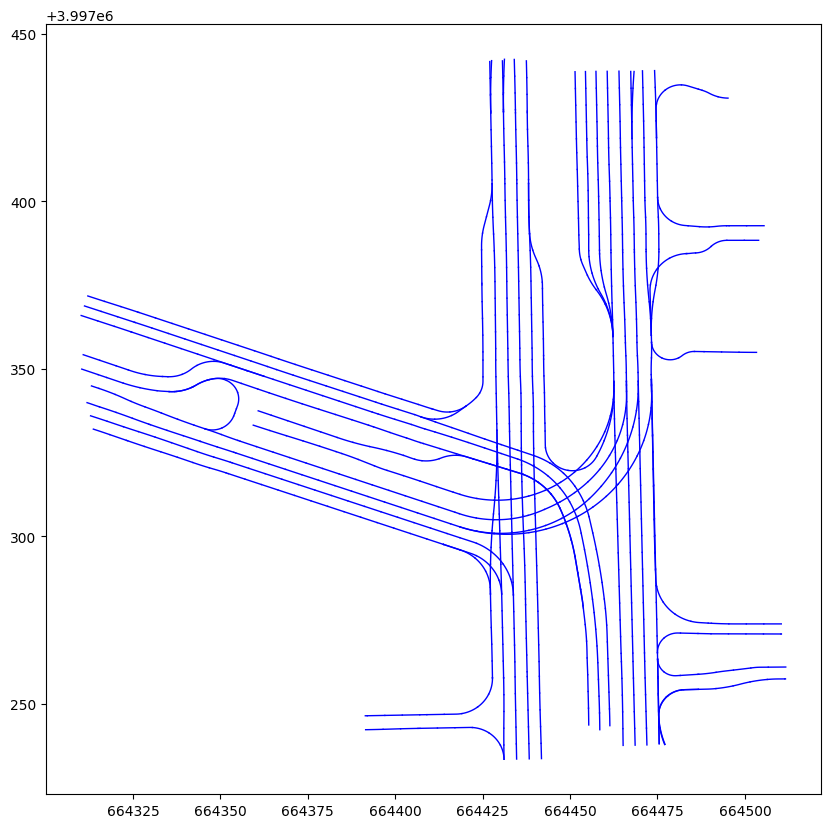

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# for boundary in boundaries:
#     ax.plot(boundary[:, 0], boundary[:, 1], color="blue", linewidth=1.0, alpha=1.0)
for map_segment in map_segments:
    ax.plot(map_segment[:, 0], map_segment[:, 1], linewidth=1.0, alpha=1.0, color="blue")
